http://www.pnas.org/content/93/19/10078.long

## Packages and formating

Import packages

In [92]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.interpolate import interp1d
from matplotlib import rc

commands and definitions for nice latex rendering

In [93]:
#for latex-rendering. (I guess with a lot of redundancy.. but it works!)
rc('text', usetex=True) #
plt.rcParams['text.usetex'] = True #this line turns "ticks" on axis into latex  (i think is it the same function as the line above. not sure. )
plt.rcParams['text.latex.unicode'] = True 
#for the size of the exported figures
plt.rcParams['figure.figsize'] = (24, 18)
rc('text.latex', preamble=r'\usepackage{cmbright}')#this line turns text in legends for instance into latex


def round_to_n(x, n):
    " Round x to n significant figures "
    return round(x, -int(math.floor(np.sign(x) * math.log10(abs(x)))) + n)

def str_fmt(x, n=2):
    " Format x into nice Latex rounding to n"
    if x<0.1:
        if x!=.01 and x!=.001 and x!=.0001 and x!=.00001:
            power = int(np.log10(round_to_n(x, 0)))-1
            mypower=int(math.floor(np.sign(x) * math.log10(abs(x))))
            f_SF = round_to_n(x, n) * pow(10, -power)
            f_SF = math.floor(x*10**(-mypower+2))/100
            return r"${} \, 10^{{ {} }}$".format(f_SF, mypower)
        else:
            power = int(np.log10(round_to_n(x, 0)))
            f_SF = round_to_n(x, n) * pow(10, -power)
            return r"${} \, 10^{{ {} }}$".format(f_SF, power)
    elif x>99:
        power = int(np.log10(round_to_n(x, 0)))
        f_SF = round_to_n(x, n) * pow(10, -power)
        return r"${} \, 10^{{ {} }}$".format(f_SF, power)
    else:
        return r"${}$".format(x)
    
def str_fmt_round_numb(x, n=1):
    " Format x into nice Latex rounding to n"
    if x<0.1:
        power = int(np.log10(round_to_n(x, 0)))-1
        f_SF = round_to_n(x, n) * pow(10, -power)
        return r"${} \, 10^{{ {} }}$".format(f_SF, power)
    elif x>99:
        power = int(np.log10(round_to_n(x, 0)))
        f_SF = round_to_n(x, n) * pow(10, -power)
        return r"${} \, 10^{{ {} }}$".format(f_SF, power)
    else:
        return r"${}$".format(x)

def str_fmt_name_fig(x, n=2):
    " Format x into nice text - rounding to n"
    if x<0.1:
        if x!=.01 and x!=.001 and x!=.0001 and x!=.00001:
            power = int(np.log10(round_to_n(x, 0)))-1
            mypower=int(math.floor(np.sign(x) * math.log10(abs(x))))
            f_SF = round_to_n(x, n) * pow(10, -power)
            f_SF = math.floor(x*10**(-mypower+2))/100
            return r"{}*10({})".format(f_SF, mypower)
        else:
            power = int(np.log10(round_to_n(x, 0)))
            f_SF = round_to_n(x, n) * pow(10, -power)
            return r"{}*10^({ })".format(f_SF, power)
    elif x>99:
        power = int(np.log10(round_to_n(x, 0)))
        f_SF = round_to_n(x, n) * pow(10, -power)
        return r"{}*10^({ })".format(f_SF, power)
    else:
        return r"{}$".format(x)
    


## Endode equations of the model and a set of default parameters

Choose values for parameters

In [94]:
scale = 1

tmax = 30        #solve the system of ODEs from t=0 to tmax (about 30 min for the cell to divide)
tmaxLONG = 1000  #what would be the steady state? (look at longer times)
 


WTV = 0.0023*scale  #not used in the code - small to have a small input in the cascade, cf Ferrell.. *)
rasgapV = .0002*scale # not used 

k11V = 1 #(* randomly chosen *)
k12V = 1

d11V = 1 #(* randomly chosen *)
d12V = 1 #(* randomly chosen *)
a11V = 10000/scale #(* randomly chosen *)
a12V = 10000/scale #(* randomly chosen *)
nn = 10

mostotV = .003*scale
mektotV = 1.2*scale #(*1.2*)
mekpasetotV = .0003*scale
mapktotV = 1.2*scale
mapkpasetotV = .12*scale
e2totV = 0.0003*scale


a1V = 1000/scale
a2V = 1000/scale
a3V = 1000/scale #(* for crossing 10 *)
a4V = 1000/scale #(* for crossing 500 *)
a5V = 1000/scale
a6V = 1000/scale
a7V = 1000/scale
a8V = 1000/scale
a9V = 1000/scale
a10V = 1000/scale


d1V = 150 #(* for crossing 15 *)
d2V = 150
d3V = 150
d4V = 150
d5V = 150
d6V = 150
d7V = 150
d8V = 150
d9V = 150
d10V = 150


k1V = 150
k2V = 150
k3V = 150
k4V = 150
k5V = 150
k6V = 150
k7V = 150
k8V = 150
k9V = 150
k10V = 150

rasgtp_inputV=1*scale

Encode equations of the model

In [95]:
var_names = 'mos', 'mose1', 'mosstar', 'mosstare2', 'mek', 'mekmosstar', 'mekstar', 'mekstarmekpase', 'mekstarmosstar', \
    'mekstarstar', 'mekstarstarmekpase', 'mapk', 'mapkmekstarstar', 'mapkstar', \
    'mapkstarmekstarstar', 'mapkstarstar', 'mapkstarmapkpase', \
    'mapkstarstarmapkpase'
    
params_names = 'mostot', 'e2tot', 'mektot', 'mekpasetot', 'mapktot', 'mapkpasetot', \
    'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a7', 'a8', 'a9', 'a10', \
    'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd8', 'd9', 'd10', \
    'k1', 'k2', 'k3', 'k4', 'k5', 'k6', 'k7', 'k8', 'k9', 'k10','WT', 'rasgdp', 'WE1', 'WsE2','rasgtp_input'

def equationsmodel(var, t, params):
    
    mos, mose1, mosstar, mosstare2, mek, mekmosstar, mekstar, mekstarmekpase, mekstarmosstar,\
    mekstarstar,mekstarstarmekpase, mapk, mapkmekstarstar, mapkstar, \
    mapkstarmekstarstar, mapkstarstar, mapkstarmapkpase, \
    mapkstarstarmapkpase = var
    
    mostot, e2tot, mektot, mekpasetot, mapktot, mapkpasetot, \
    a1, a2, a3, a4, a5, a6, a7, a8, a9, a10, \
    d1, d2, d3, d4, d5, d6, d7, d8, d9, d10, \
    k1, k2, k3, k4, k5, k6, k7, k8, k9, k10, WT, rasgdp, WE1, WsE2, rasgtp_input = params
    
    dmos = -a1*(mostot - mosstar - mose1 - mosstare2 - mekmosstar - \
    mekstarmosstar)*(rasgtp_input - mose1) + d1*mose1 +\
    k2*mosstare2
    
    dmose1 = a1*(mostot - mosstar - mose1 - mosstare2 - mekmosstar - \
    mekstarmosstar)*(rasgtp_input - mose1) -(d1+k1)*mose1
    
    dmosstar = -a2*mosstar*(e2tot - mosstare2) + d2*mosstare2 + k1*mose1 + \
    (k3 + d3)*mekmosstar -  a3*mosstar*(mektot - mekstar - mekstarstar - \
    mekstarmekpase - mekstarstarmekpase - mekmosstar - mekstarmosstar - \
    mapkmekstarstar - mapkstarmekstarstar) + (k5 + d5)* mekstarmosstar - \
    a5*mekstar*mosstar
      
    dmosstare2 = a2*mosstar*(e2tot - mosstare2) - (d2 + k2)*mosstare2
    
    dmek = -a3*(mektot - mekstar - mekstarstar - mekstarmekpase - \
    mekstarstarmekpase - mekmosstar - mekstarmosstar - mapkmekstarstar - \
    mapkstarmekstarstar)*mosstar + d3*mekmosstar + k4*mekstarmekpase
     
    dmekmosstar = a3*(mektot - mekstar - mekstarstar - mekstarmekpase - \
    mekstarstarmekpase - mekmosstar - mekstarmosstar - mapkmekstarstar - \
    mapkstarmekstarstar)*mosstar - (d3 + k3)*mekmosstar
    
    dmekstar = -a4*mekstar*(mekpasetot - mekstarmekpase - mekstarstarmekpase)\
    + d4*mekstarmekpase + k3*mekmosstar + k6*mekstarstarmekpase + \
    d5*mekstarmosstar - a5*mekstar*mosstar
    
    dmekstarmekpase = a4*mekstar*(mekpasetot - mekstarmekpase - \
    mekstarstarmekpase)-(d4 + k4)*mekstarmekpase 

    dmekstarmosstar = a5*mekstar*mosstar - (d5 + k5)*mekstarmosstar
    
    dmekstarstar = k5*mekstarmosstar - a6*mekstarstar*(mekpasetot - 
    mekstarmekpase - mekstarstarmekpase) + d6*mekstarstarmekpase - \
    a7*mekstarstar*(mapktot - mapkstar - mapkstarstar - mapkstarmapkpase - \
    mapkstarstarmapkpase - mapkmekstarstar - mapkstarmekstarstar) + \
    (d7 + k7)*mapkmekstarstar + (d9 + k9)*mapkstarmekstarstar - \
    a9*mapkstar*mekstarstar
    
    dmekstarstarmekpase = a6*mekstarstar*(mekpasetot - mekstarmekpase \
    - mekstarstarmekpase) - (d6 + k6)*mekstarstarmekpase
    
    dmapk = -a7*(mapktot - mapkstar - mapkstarstar - mapkstarmapkpase - \
    mapkstarstarmapkpase - mapkmekstarstar - mapkstarmekstarstar)*mekstarstar \
    + d7*mapkmekstarstar + k8*mapkstarmapkpase
    
    dmapkmekstarstar = a7*(mapktot - mapkstar - mapkstarstar \
    - mapkstarmapkpase - mapkstarstarmapkpase - mapkmekstarstar - mapkstarmekstarstar)*mekstarstar - (d7 + k7)*mapkmekstarstar
    
    dmapkstar = k7*mapkmekstarstar - a8*mapkstar*(mapkpasetot - \
    mapkstarmapkpase - mapkstarstarmapkpase) + d8*mapkstarmapkpase - \
    a9*mapkstar*mekstarstar + d9*mapkstarmekstarstar + k10*mapkstarstarmapkpase
    
    dmapkstarmekstarstar =a9*mapkstar*mekstarstar - (d9 + k9)*mapkstarmekstarstar
    
    dmapkstarstar = -a10*mapkstarstar*(mapkpasetot - mapkstarmapkpase - \
    mapkstarstarmapkpase) + d10*mapkstarstarmapkpase + k9*mapkstarmekstarstar 
    
    dmapkstarmapkpase = a8*mapkstar*(mapkpasetot - mapkstarmapkpase - 
    mapkstarstarmapkpase) - (d8 + k8)*mapkstarmapkpase
    
    dmapkstarstarmapkpase = a10*mapkstarstar*(mapkpasetot - mapkstarmapkpase - \
    mapkstarstarmapkpase) - (d10 + k10)*mapkstarstarmapkpase
     
    return [dmos, dmose1,dmosstar,dmosstare2,dmek,dmekmosstar,dmekstar, \
    dmekstarmekpase, dmekstarmosstar, dmekstarstar, dmekstarstarmekpase, \
    dmapk, dmapkmekstarstar, dmapkstar, dmapkstarmekstarstar, dmapkstarstar, \
    dmapkstarmapkpase, dmapkstarstarmapkpase]


In [96]:
param_v  = [mostotV, e2totV, mektotV, mekpasetotV, mapktotV, mapkpasetotV, \
    a1V, a2V, a3V, a4V, a5V, a6V, a7V, a8V, a9V, a10V, \
    d1V, d2V, d3V, d4V, d5V, d6V, d7V, d8V, d9V, d10V, \
    k1V, k2V, k3V, k4V, k5V, k6V, k7V, k8V, k9V, k10V,WTV,e2totV,0,0,rasgtp_inputV]

In [97]:
print(np.asarray(params_names),param_v)
print(params_names[37])

['mostot' 'e2tot' 'mektot' 'mekpasetot' 'mapktot' 'mapkpasetot' 'a1' 'a2'
 'a3' 'a4' 'a5' 'a6' 'a7' 'a8' 'a9' 'a10' 'd1' 'd2' 'd3' 'd4' 'd5' 'd6'
 'd7' 'd8' 'd9' 'd10' 'k1' 'k2' 'k3' 'k4' 'k5' 'k6' 'k7' 'k8' 'k9' 'k10'
 'WT' 'rasgdp' 'WE1' 'WsE2' 'rasgtp_input'] [0.003, 0.0003, 1.2, 0.0003, 1.2, 0.12, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 0.0023, 0.0003, 0, 0, 1]
rasgdp


In [98]:
###################################
# INITIAL CONDTIONS
###################################

initialcond = np.zeros(len(var_names))
initialcond[0] = param_v[0]
initialcond[4] = param_v[2]
initialcond[11] = param_v[4]
###################################
# time array & array to store the output for various input levels of sos
###################################

tStop = tmax
tInc = 0.01
t = np.arange(0., tStop, tInc)

print("The initial conditions are {}(0) = {}, {}(0) = {} and {}(0) = {}".format(var_names[0],params_names[0], \
                                                                 var_names[4],params_names[2], \
                                                                 var_names[11],params_names[4]))
len(initialcond)



The initial conditions are mos(0) = mostot, mek(0) = mektot and mapk(0) = mapktot


18

## Loop over input, solve equations, and store value reached by the output 

We have a system with one input (the concentration of rasdtp which is not directly a parameter of our model, it is computed from the value of rasgdp...). We take $maxn$ different input values and plot only 5 solutions. 

In [116]:
maxn = 100
inputlist=np.logspace(-10, 1, num=maxn)*scale
maxplots=5;
selectedinput=range(1,maxn,divmod(maxn,maxplots)[0])#we plot only n=maxplots plots 
storeoutput=[]
print(params_names[4],param_v[4])

mapktot 1.2


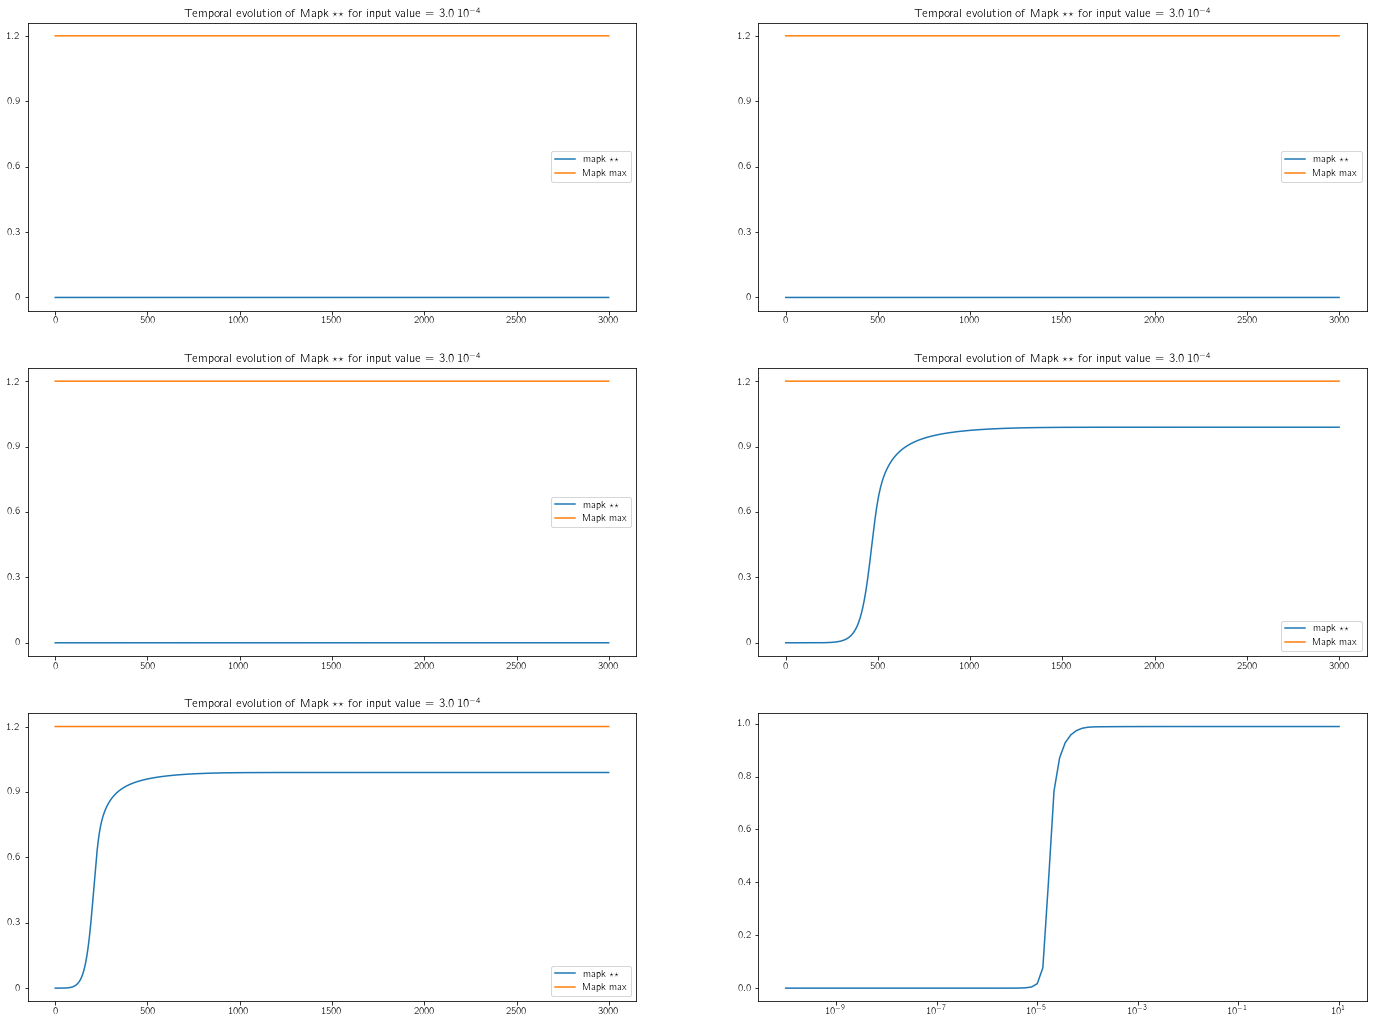

In [119]:
#to number plots    np.arange(1,math.floor(len(range(0,maxn,divmod(maxn,10)[0])))+1)

fig=plt.figure()
plotnumber=0
output=np.zeros(len(inputlist))

for kk in range(len(inputlist)):
    #value of input:
    param_v[40]=inputlist[kk]
    #actually solving the equations:
    psoln = odeint(equationsmodel, initialcond, t, args=(param_v,))
    output[kk]=psoln[len(t)-1,15]
    if kk in selectedinput:
        plotnumber=plotnumber+1
        plt.subplot(math.floor(len(selectedinput)/2)+1,2,plotnumber)
        plt.plot(psoln[:,15],label=r"$ \textnormal{mapk \star \star}$")
        #plot max value of mapk star star
        plt.plot(np.ones(len(t))*param_v[4],label=r" \textnormal{Mapk max}")
        plt.legend()
        plt.title(r'Temporal evolution of Mapk $\star \star$ for input value = {}'.format(str_fmt(param_v[37],n=2)))
        plt.yticks([0, param_v[4]/4, param_v[4]/2, 3*param_v[4]/4, param_v[4]],
        ['$0$', r'{}'.format(str_fmt(param_v[4]/4)), r'{}'.format(str_fmt(param_v[4]/2)),r'{}'.format(str_fmt_round_numb(round_to_n(3*param_v[4]/4,2))), r'{}'.format(str_fmt(param_v[4]))])

ax=plt.subplot(math.floor(len(selectedinput)/2)+1,2,plotnumber+1)
plt.plot(inputlist,output)
ax.set_xscale('log')
plt.show()


In [ ]:
def hillcoef(input,output,equationsmodel,initialcond, t,param_v):
    "compute Hill coef"
    output=storeerk
    input1=sostotlist[1:]
    maxoutput=max(output)
    #
    approxloc09=np.abs(output-.9*maxoutput).argmin()#position in the array of approximate location
    input09=np.linspace(input1[approxloc09-2],input1[approxloc09+2],100)#generate more output points near that approximate location 
    output09=[-1]#initiate the local output array
    #
    #
    for i in range(0,len(input09)):
        psoln = odeint(equationsswitch, initialcond, t, args=([WTV, a11V, a12V, d11V, d12V, k11V, k12V, rasgapV,input09[i]],))
        rasgtp=WTV-(psoln[:,0]+psoln[:,1]+psoln[:,2])
        output09=np.append(output09,[rasgtp[(len(rasgtp)-1)]])
    # 
    output09=output09[1:]
    inversef=interp1d(output09,input09)
    loc09=inversef(.9*maxoutput)
    #
    #
    approxloc01=np.abs(output-.1*maxoutput).argmin()#position in the array of approximate location
    input01=np.linspace(input1[approxloc01-2],input1[approxloc01+2],100)#generate more output points near that approximate location 
    output01=[-1]
    #
    #
    for i in range(0,len(input01)):
        psoln = odeint(equationsswitch, initialcond, t, args=([WTV, a11V, a12V, d11V, d12V, k11V, k12V, rasgapV,input01[i]],))
        rasgtp=WTV-(psoln[:,0]+psoln[:,1]+psoln[:,2])
        output01=np.append(output01,[rasgtp[(len(rasgtp)-1)]])
    # 
    output01=output01[1:]
    inversef=interp1d(output01,input01)
    loc01=inversef(.1*maxoutput)
    #
    hillcoef=math.log(81)/math.log(loc09/loc01)
    hillcoeferk=np.append(hillcoeferk,hillcoef)
